Nota generada a partir de la [liga1](https://www.dropbox.com/s/jfrxanjls8kndjp/Diferenciacion_e_Integracion.pdf?dl=0).

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

```
docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_numerical -p 8888:8888 -p 8786:8786 -p 8787:8787 -d palmoreck/jupyterlab_numerical:1.1.0
```

Detener el contenedor de docker:

```
docker stop jupyterlab_local
```


Los métodos revisados en esta nota de integración numérica serán utilizados más adelante para revisión de herramientas en Python para **perfilamiento de código: uso de cpu y memoria**. También serán referidos en el capítulo de **cómputo en paralelo**.

In [1]:
import math
import numpy as np

from scipy.integrate import quad
import matplotlib.pyplot as plt

# Integración Numérica

En lo siguiente consideramos que las funciones del integrando están en $\mathcal{C}^2$ en el conjunto de integración (ver final de nota [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb) para definición de $\mathcal{C}^2$).

Las reglas o métodos por cuadratura nos ayudan a aproximar integrales con sumas de la forma:

$$\displaystyle \int_a^bf(x)dx \approx \displaystyle \sum_{i=0}^nw_if(x_i)$$

donde: $w_i$ es el peso para el nodo $x_i$, $f$ se llama integrando y $[a,b]$ intervalo de integración. Los valores $f(x_i)$ se asumen conocidos.

Todas las reglas o métodos por cuadratura se obtienen con interpoladores polinomiales del integrando (por ejemplo usando la representación de Lagrange) o también con el teorema Taylor (ver nota [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb) para éste teorema).

Se realizan aproximaciones numéricas por:
* Desconocimiento de la función en todo el intervalo $[a,b]$ y sólo se conoce en los nodos su valor.
* Inexistencia de antiderivada o primitiva del integrando. Por ejemplo: 

$$\displaystyle \int_a^be^{-\frac{x^2}{2}}dx$$ con $a,b$ números reales.

Dependiendo de la ubicación de los nodos y pesos es el método de cuadratura que resulta:

* Newton-Cotes si los nodos y pesos son equidistantes como la regla del rectángulo, trapecio y Simpson (con el teorema de Taylor o interpolación es posible obtener tales fórmulas).
* Cuadratura Gaussiana si se desea obtener reglas o fórmulas que tengan la mayor exactitud posible. Ejemplos de este tipo de cuadratura se tiene la regla por cuadratura Gauss-Legendre en [-1,1] o Gauss-Hermite para el caso de integrales en $[-\infty, \infty]$ con integrando $e^{-x^2}f(x)$.

**Comentario:**

Los métodos de integración numérica por Newton-Cotes o cuadratura Gaussiana pueden extenderse a más dimensiones, sin embargo incurren en lo que se conoce como la **maldición de la dimensionalidad** que para el caso de integración numérica consiste en la gran cantidad de evaluaciones que deben realizarse de la función del integrando para tener una exactitud pequeña, por ejemplo con un número de nodos igual a $10^4$, una distancia entre ellos de $.1$ y una integral en $4$ dimensiones para la regla por Newton Cotes del rectángulo, se obtiene una exactitud de $2$ dígitos. Como alternativa a los métodos por cuadratura anteriores para las integrales de más dimensiones se tienen los **métodos de integración por el método Monte Carlo** que generan aproximaciones con una exactitud moderada (del orden de $\mathcal{O}(n^{-1/2})$ con $n$ número de nodos) para un número de puntos moderado independiente de la dimensión.


## Newton-Cotes

Si el conjunto de nodos $x_i, i=0,1,\dots,n$ cumple $x_{i+1}-x_i=h, \forall i=0,1,\dots,n-1$ con $h$ (espaciado) constante y se aproxima la función del integrando $f$ con un polinomio en $(x_i,f(x_i)) \forall i=0,1,\dots,n$ entonces se tiene un método de integración numérica por Newton-Cotes (o reglas o fórmulas por Newton-Cotes).

<p align="centered">
<img src="https://drive.google.com/uc?export=view&id=18fwDv32B7jKDaHL_cekBDUM8wpYVdjoS" alt="a" heigth="500" width="500">
</p>

En el dibujo: a),b) y c) se integra numéricamente por Newton-Cotes. d) es por cuadratura Gaussiana.


**Comentario:** si la fórmula por Newton-Cotes involucra el valor de la función en los extremos se llama cerrada, si no los involucra se les llama abiertas. En el dibujo d) es abierta.

El dibujo anterior muestra que puede subdivirse el intervalo de integración en una mayor cantidad de subintervalos, lo cual para la función $f$ mostrada es benéfico pues se tiene mejor aproximación (en la práctica esto será bueno? recuérdese los errores de redondeo de la nota [1.2.Sistema_de_punto_flotante](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.2.Sistema_de_punto_flotante.ipynb)). Los métodos que utilizan la idea anterior de dividir en subintervalos se les conoce como **métodos de integración numérica compuestos** en contraste con los simples. 

**Comentario:** Para las reglas compuestas se divide el intervalo $[a,b]$ en $n$ subinteralos $[x_{i-1},x_i], i=1,\dots,n$ con $x_0=a<x_1<\dots<x_{n-1}<x_n=b$ y se considera una partición regular, esto es: $x_i-x_{i-1}=\hat{h}$ con $\hat{h}=\frac{h}{n}$ y $h=b-a$. En este contexto se realiza la aproximación:

$$\displaystyle \int_a^bf(x)dx = \sum_{i=1}^n\int_{x_{i-1}}^{x_i}f(x)dx.$$

Para las siguientes reglas se considerará la función $f(x)=e^{-x^2}$ la cual tiene una forma:

In [2]:
f=lambda x: np.exp(-x**2)

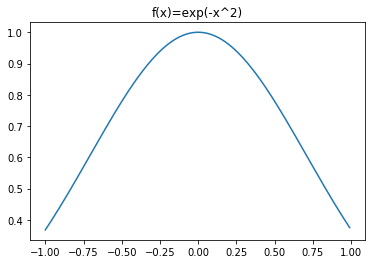

In [3]:
x=np.arange(-1,1,.01)
plt.plot(x,f(x))
plt.title('f(x)=exp(-x^2)')
plt.show()

El valor de la integral $\int_0^1e^{-x^2}dx$ es:

In [4]:
obj, err = quad(f, 0, 1)

In [5]:
(obj,err)

(0.7468241328124271, 8.291413475940725e-15)

**Obs:** el segundo valor regresado `err`, es una cota superior del error.

### Regla simple del rectángulo

Denotaremos a esta regla como $Rf$. En este caso se aproxima el integrando $f$ por un polinomio de grado **cero** con nodo en $x_1 = \frac{a+b}{2}$. Entonces: 

$$\displaystyle \int_a^bf(x)dx \approx \int_a^bf(x_1)dx = (b-a)f(x_1)=(b-a)f\left( \frac{a+b}{2} \right ) = hf(x_1)$$

con $h=b-a, x_1=\frac{a+b}{2}$.


<p align="centered">
<img src="https://drive.google.com/uc?export=view&id=1W7K581_n95ez2KXcjWs61CvZqY9EVMH8" heigth="200" width="200">
</p>

**Ejemplo de implantación de regla simple de rectángulo: usando math**

Utilizar la regla simple del rectángulo para aproximar la integral $\displaystyle \int_0^1e^{-x^2}dx$.

In [6]:
f=lambda x: math.exp(-x**2) #using math library

In [7]:
def Rf(f,a,b):
    nodo=a+(b-a)/2.0 #mid point formula to minimize rounding errors
    return f(nodo) #polinomio de grado cero

In [8]:
Rf(f,0,1)

0.7788007830714049

### Regla compuesta del rectángulo

En cada subintervalo se aplica la regla simple $Rf$, esto es:

$$\displaystyle \int_{x_{i-1}}^{x_i}f(x)dx \approx R_i(f) \forall i=1,\dots,n.$$

De forma sencilla se puede ver que la regla compuesta del rectángulo $R_c(f)$ se escribe:

$$R_c(f) = \displaystyle \sum_{i=1}^n(x_i-x_{i-1})f\left( \frac{x_i+x_{i-1}}{2}\right) = \frac{h}{n}\sum_{i=1}^nf\left( \frac{x_i+x_{i-1}}{2}\right)$$

con $h=b-a$ y $n$ número de subintervalos.

<p align="centered">
<img src="https://drive.google.com/uc?export=view&id=1lSQp4VEKRVsF38GKzaME-FhTzRVDFMIA" heigth="200" width="200">
</p>

**Nota:** Los nodos para el caso del rectángulo se obtienen con la fórmula: $x_i = a +(i+\frac{1}{2})\hat{h}, \forall i=0,\dots,n-1$.

**Ejemplo de implantación de regla compuesta de rectángulo: usando math**

Utilizar la regla compuesta del rectángulo para aproximar la integral $\int_0^1e^{-x^2}dx$.

In [9]:
f=lambda x: math.exp(-x**2) #using math library

In [10]:
def Rcf(f,a,b,n): #Rcf: rectángulo compuesto para f
    """
    Compute numerical approximation using rectangle or mid-point method in 
    an interval.
    Nodes are generated via formula: x_i = a+(i+1/2)h_hat for i=0,1,...,n and h_hat=(b-a)/n
    Args:
        f (lambda expression): lambda expression of integrand
        a (int): left point of interval
        b (int): right point of interval
        n (int): number of subintervals
    Returns:
        Rcf (float) 
    """
    h_hat=(b-a)/n
    nodes=[a+(i+1/2)*h_hat for i in range(0,n)]
    sum_res=0
    for node in nodes:
        sum_res=sum_res+f(node)
    return h_hat*sum_res 

In [11]:
aprox_1=Rcf(f,0,1,1)
aprox_1

0.7788007830714049

In [12]:
aprox_2=Rcf(f,0,1,2)
aprox_2

0.7545979437721995

In [13]:
aprox_2=Rcf(f,0,1,2)
aprox_2

0.7545979437721995

In [14]:
aprox_3=Rcf(f,0,1,10**3)
aprox_3

0.746824163469049

Y se puede evaluar el error de aproximación con el error relativo:

In [15]:
def err_relativo(aprox, obj):
    return math.fabs(aprox-obj)/math.fabs(obj) #obsérvese el uso de la librería math

In [16]:
obj, err = quad(f, 0, 1)
(err_relativo(aprox_1,obj), err_relativo(aprox_2,obj), err_relativo(aprox_3,obj))

(0.04281684114646715, 0.010409158754012628, 4.1049318789768585e-08)

**Pregunta: será el método del rectángulo un método estable numéricamente bajo el redondeo?** Ver nota [1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo.ipynb) para definición de estabilidad numérica de un algoritmo.

In [17]:
aprox_4=Rcf(f,0,1,10**5)
aprox_4

0.7468241328154887

In [18]:
err_relativo(aprox_4,obj)

4.099426997862257e-12

Al menos para este ejemplo con $10^5$ nodos parece ser numéricamente estable... 

### Regla compuesta del trapecio

<p align="centered">
<img src="https://drive.google.com/uc?export=view&id=1D9W8vNVfcKNGa1qA6STBwOqqmYc9p32z" heigth="200" width="200">
</p>

En cada subintervalo se aplica la regla simple $Tf$, esto es:

$$\displaystyle \int_{x_{i-1}}^{x_i}f(x)dx \approx T_i(f) \forall i=1,\dots,n.$$

Con $T_i(f) = \frac{(x_i-x_{i-1})}{2}(f(x_i)+f(x_{i-1}))$.

De forma sencilla se puede ver que la regla compuesta del trapecio $T_c(f)$ se escribe como:

$$T_c(f) = \displaystyle \frac{h}{2n}\left[f(x_0)+f(x_n)+2\displaystyle\sum_{i=1}^{n-1}f(x_i)\right]$$

con $h=b-a$ y $n$ número de subintervalos.

**Nota:** Los nodos para el caso del trapecio se obtienen con la fórmula: $x_i = a +i\hat{h}, \forall i=1,\dots,n$.

**Ejemplo de implantación de regla compuesta del trapecio: usando numpy**

Utilizar la regla compuesta del trapecio para aproximar la integral $\int_0^1e^{-x^2}dx$. Calcular error relativo y realizar una gráfica de $n$ vs Error relativo para $n=1,10,100,1000,10000$.

In [19]:
f=lambda x: np.exp(-x**2) #using numpy library

In [20]:
def Tcf(n,f,a,b): #Tcf: trapecio compuesto para f
    """
    Compute numerical approximation using trapezoidal rule in 
    an interval.
    Nodes are generated via numpy
    Args:
        f (lambda expression): lambda expression of integrand
        a (int): left point of interval
        b (int): right point of interval
        n (int): number of subintervals
    Returns:
        Tcf (float) 
    """
    h=b-a
    nodes=np.linspace(a,b,n+1)
    sum_res=sum(f(nodes[1:-1]))
    return h/(2*n)*(f(nodes[0])+f(nodes[-1])+2*sum_res)

Graficamos:

In [21]:
numb_of_subintervals=(1,10,100,1000,10000)

**Primera opción:**

In [22]:
approx = np.array([Tcf(n,f,0,1) for n in numb_of_subintervals])

In [23]:
def err_relativo(aprox, obj):
    return np.abs(aprox-obj)/np.abs(obj) #obsérvese el uso de la librería numpy

In [24]:
err_relativo_res = err_relativo(approx,obj)

In [25]:
err_relativo_res

array([8.42024373e-02, 8.21259857e-04, 8.20989064e-06, 8.20986364e-08,
       8.20987410e-10])

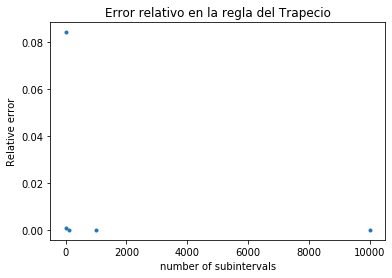

In [26]:
plt.plot(numb_of_subintervals,err_relativo_res,'.')
plt.xlabel('number of subintervals')
plt.ylabel('Relative error')
plt.title('Error relativo en la regla del Trapecio')
plt.show()

**Segunda opción:**

In [27]:
from functools import partial

Ver [liga](https://stackoverflow.com/questions/15331726/how-does-functools-partial-do-what-it-does) para una explicación de `partial` y [liga2](https://stackoverflow.com/questions/10834960/how-to-do-multiple-arguments-to-map-function-where-one-remains-the-same-in-pytho), [liga3](https://stackoverflow.com/questions/47859209/how-to-map-over-a-function-with-multiple-arguments-in-python) para ejemplos de uso.

In [28]:
approx=map(partial(Tcf,f=f,a=0,b=1),numb_of_subintervals) #regresa un iterator

In [29]:
def err_relativo(aprox_map, obj):
    for ap in aprox_map:
        yield math.fabs(ap-obj)/math.fabs(obj) #obsérvese el uso de la librería math

In [30]:
err_relativo_res = err_relativo(approx,obj)

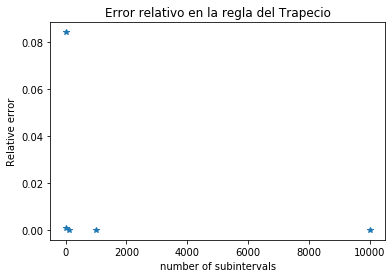

In [31]:
plt.plot(numb_of_subintervals,list(err_relativo_res),'*')
plt.xlabel('number of subintervals')
plt.ylabel('Relative error')
plt.title('Error relativo en la regla del Trapecio')
plt.show()

In [32]:
approx=map(partial(Tcf,f=f,a=0,b=1),numb_of_subintervals) #regresa un iterator

In [33]:
err_relativo_res = err_relativo(approx,obj)

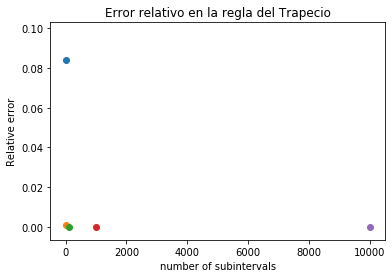

In [34]:
[plt.scatter(n,err_rel) for n,err_rel in zip(numb_of_subintervals,err_relativo_res)]
plt.xlabel('number of subintervals')
plt.ylabel('Relative error')
plt.title('Error relativo en la regla del Trapecio')
plt.show()

### Regla compuesta de Simpson

<p align="centered">
<img src="https://drive.google.com/uc?export=view&id=1ytLsDbXmtXzQdwompjtJgtb1HOV0JdcR" heigth="200" width="200">
</p>

**Comentario:**

La regla del rectángulo o del trapecio tienen un error de orden $\mathcal{O}(h^2)$ independientemente de si se está aproximando integrales de una o más dimensiones. Supóngase que se utilizan $n$ nodos para tener un valor de espaciado igual a $h$, entonces para $d$ dimensiones se requerirían $N=n^d$ evaluaciones del integrando, o bien, si se tiene un valor de $N$ igual a $10, 000$ y $d=4$ dimensiones el error sería del orden $\mathcal{O}(N^{-2/d})$ lo que implicaría un valor de $h=.1$ para aproximadamente sólo **dos dígitos** correctos en la aproximación (para el enunciado anterior recuérdese que $h$ es proporcional a $n^{-1}$ y $n$ = $N^{1/d}$). Este esfuerzo enorme de evaluar $N$ veces el integrando para una exactitud pequeña se debe al problema de generar puntos para *llenar* un espacio $d$-dimensional y se conoce con el nombre de la maldición de la dimensionalidad, **the curse of dimensionality**.

# Integración por el método de Monte Carlo

Los métodos de integración numérica por Monte Carlo son similares a los métodos por cuadratura en el sentido que se eligen puntos en los que se evaluará el integrando para sumar sus valores. La diferencia esencial con los métodos por cuadratura es que en el método de integración por Monte Carlo los puntos son seleccionados de una forma *aleatoria* (de hecho es pseudo-aleatoria pues se generan con un programa de computadora) en lugar de generarse con una fórmula.

**Ejercicios**

1. Resuelve los ejercicios y preguntas de la nota.


**Referencias**

1. R. L. Burden, J. D. Faires, Numerical Analysis, Brooks/Cole Cengage Learning, 2005.

2. M. T. Heath, Scientific Computing. An Introductory Survey, McGraw-Hill, 2002.

3. Nota [1.2.Sistema_de_punto_flotante](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.2.Sistema_de_punto_flotante.ipynb))

4. Nota [1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.3.Condicion_de_un_problema_y_estabilidad_de_un_algoritmo.ipynb)

5. [1.4.Polinomios_de_Taylor_y_diferenciacion_numerica](https://github.com/ITAM-DS/analisis-numerico-computo-cientifico/blob/master/temas/I.computo_cientifico/1.4.Polinomios_de_Taylor_y_diferenciacion_numerica.ipynb)